In [1]:
import numpy  as np                       
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import time, sys  
import random

# A two-stage bi-fidelity approximation (2SBF)

The goal of the algorithm is to minimise the error incurred in both the standard (SBF) and the transformed (TBF) algorithms, by combining the two sequentially.

The steps in the new algorithm are as follows:

1. Compute the SBF and store the matrix B_sbf.
2. Transform B_sbf and store shock locations.
3. Compute the TBF and store the matrix B_tbf.
4. Using the shock locations, undo the transformation on B_tbf, to get B_2bf.

In [2]:
%matplotlib inline
#%%capture
#!pip install ipython-autotime
%reload_ext autotime

time: 153 µs


In [3]:
# code settings
nx_lf     = 32
nx_hf     = 256
samples   = 100
eps       = 1e-6
save_plot = 1 # toggle flag to save figures

time: 298 µs


In [4]:
# burgers' solver
random.seed(42) # fix seed for np.random
sli.seed(43)    # fix seed for svd/id algorithm (generating matrix with random variates)

s = np.random.uniform(5, 25, samples)
phi_lf = np.zeros((nx_lf, samples))
phi_hf = np.zeros((nx_hf, samples))

for _ in range(len(s)):
    sharpen = s[_]

    u = 1.0         
    L = 2.0        
    T = 1.0
    
    cfl = 0.1      
    periodic = 1    # periodicity on/off 

    # define initial condition   
    def ic(x, sharpen):
        xcenter = 0.5   # location of the gaussian center
        phi_ic = np.exp(-sharpen*(x - xcenter)**2) 
        return phi_ic

    x = np.linspace(0,L,samples)
    phi = np.zeros(samples)  
    for i in range(samples):
        phi[i]=ic(x[i], sharpen)

    # set initial condition   
    def initialize(nno,x,phi):
        for i in range(nno):
            phi[i]=ic(x[i], sharpen)

    # compute errors
    def compute_exact(nno,time,x,phi_exact):
        time_shift = time
        if periodic and time*u > L:
            a = divmod(time,L/u)
            time_shift = a[1]
        for i in range(nno):
            phi_exact[i]=ic(x[i]-u*time_shift, sharpen)

    # First Order Upwind
    def update_upwind(nno,dx,dt,phi):
        phi_old = phi.copy() 
        for i in range(1, nno-1):
            im = i-1
            #phi[i] = phi_old[i]-0.5*dt/dx*(phi_old[i]**2 - phi_old[im]**2) # conservative
            phi[i] = phi_old[i]-phi_old[i]*dt/dx*(phi_old[i] - phi_old[im])  

    # Lax Wendroff
    def update_laxwendroff(nno,dx,dt,phi):
        phi_old = phi.copy() 
        for i in range(1, nno-1):
            im = i-1
            ip = i+1
            phi[i] = phi_old[i]-0.5*phi_old[i]*dt/dx*((phi_old[ip]-phi_old[im])
                      -phi_old[i]*dt/dx*(-2.*phi_old[i]+phi_old[im]+phi_old[ip]))

    # set boundary condition  
    def bc(nno,x,phi,time):
        if (periodic):
            phi[0]=phi[nno-2] #apply periodicity @ x=0
            phi[nno-1]=phi[1] #apply periodicity @ x=L
        else:
            phi[0]=ic(x[0]-np.max(phi)*time, sharpen) #ncross the right boundary
            #phi[nno-1]=phi[nno-2] #zero-gradient?
            phi[nno-1]=ic(x[nno-1]-np.max(phi)*time, sharpen) #cross the right boundary

    # solve the PDE
    def solve(nno,scheme="upwind",plot=0):  
        #by default use upwind and plot solution
        start = time.time() 
        dx = L / (nno-1)    # spacing of the nodes
        x = np.linspace(0,L,nno)  #grid generation
        phi = np.zeros(nno)  
        phi_exact = np.zeros(nno)  
        initialize(nno,x,phi) #initialize
        mytime = 0
        nts = 0
        dt = cfl*dx/np.max(phi)
        while mytime < T:  #integrate up to time T
            bc(nno,x,phi,mytime)
            nts = nts + 1
            mytime = mytime + dt  
            # update the solution with a finite difference scheme (explicit)
            if scheme == "upwind": 
                update_upwind(nno,dx,dt,phi)
            elif scheme == "laxwendroff":
                update_laxwendroff(nno,dx,dt,phi)
        # compare the solution with the exact and compute the L2 norm
        compute_exact(nno,mytime,x,phi_exact)
        end = time.time()

        return phi 
    
    phi_lf[:,_] = solve(nx_lf,"upwind",0)
    phi_hf[:,_] = solve(nx_hf,"upwind",0)

time: 28.9 s


In [5]:
def id(A, HF, eps):
    """Compute interpolative decomposition"""
    k, idx, proj = sli.interp_decomp(A, eps)
    P = sli.reconstruct_interp_matrix(idx, proj)
    return np.dot(HF[:,idx[0:k]],P) 

def transform(p):
    """Transform problem into a domain that fixes the shock for all realisations"""
    grad_phi = np.zeros((p.shape[0]-1,p.shape[1]))

    for j in range(p.shape[1]):
        for i in range(p.shape[0]-1):
            grad_phi[i,j] = p[i,j] - p[i+1,j]

    shock_loc = np.zeros(p.shape[1])

    for _ in range(p.shape[1]):
        shock_loc[_] = np.argmax(grad_phi[:,_]) # get shock location

    shift_phi = np.zeros(np.shape(p))

    for _ in range(p.shape[1]):
        shift_phi[:,_] = np.roll(p[:,_], int(p.shape[0]//2 - shock_loc[_]))
    
    return shift_phi, shock_loc

time: 945 µs


In [6]:
# Step 1
B_sbf = id(phi_lf, phi_hf, eps)

# Step 2
_, sloc_bf = transform(B_sbf)

# Step 3
phi_lf_t, sloc_lf_t = transform(phi_lf)
phi_hf_t, sloc_hf_t = transform(phi_hf)
B_tbf = id(phi_lf_t, phi_hf_t, eps)

# Step 4
B_2bf = np.zeros(np.shape(B_tbf))
for _ in range(B_tbf.shape[1]):
    shift = int(B_tbf.shape[0]//2 + sloc_bf[_]*float(phi_hf.shape[0]/B_tbf.shape[0]))
    B_2bf[:,_] = np.roll(B_tbf[:,_], shift)

time: 93.5 ms


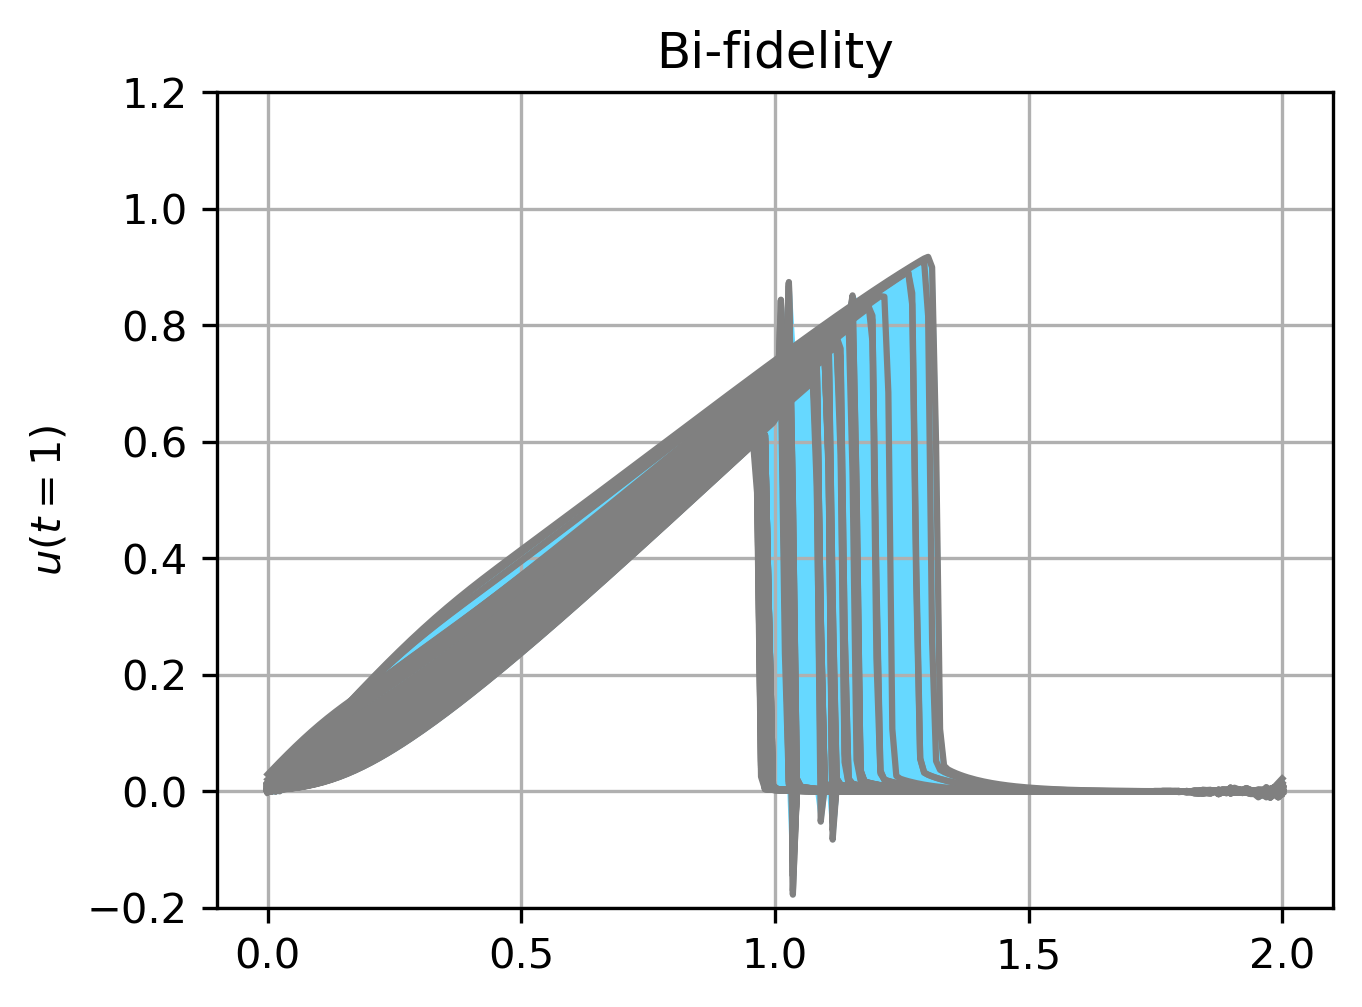

time: 551 ms


In [10]:
# plot BF results
X = np.linspace(0,L,nx_hf)

# generate uncertainty envelope
low_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    low_bnd[_] = min(B_2bf[_,:])
    
upp_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    upp_bnd[_] = max(B_2bf[_,:])

fig4 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig4.add_subplot(1,1,1)
ax.plot(X,B_2bf, '-', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_ylim([-.2,1.2])
ax.set_title('Bi-fidelity')
ax.grid('on')
ax.fill_between(X,low_bnd,upp_bnd,color='deepskyblue',alpha=0.6)      # uq bounds
if save_plot:
    plt.savefig("./figures/2bf.png",bbox_inches='tight')